In [5]:
pip install gengli

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


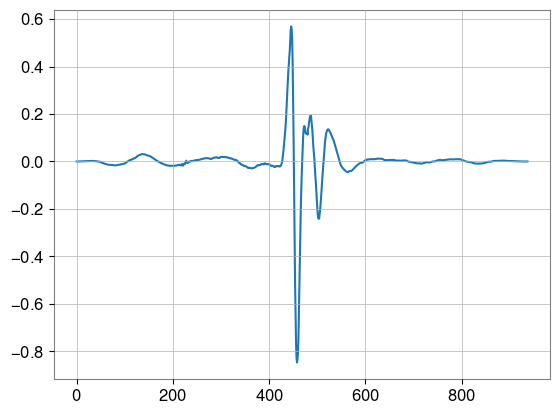

In [6]:
import gengli
import numpy as np
import matplotlib.pyplot as plt

g = gengli.glitch_generator('L1')
g_raw = g.get_glitch()

plt.plot(g_raw)

In [7]:
import numpy as np
from numpy.fft import fft, fftfreq
from scipy.interpolate import interp1d
from gwpy.timeseries import TimeSeries
from pycbc.psd import aLIGOZeroDetHighPower
from astropy import units as u
import tqdm

### Configuration
sample_rate = 1024
duration = 1.0
gps_start = 1126259456
n_samples = 10000
delta_t = 1 / sample_rate

#### PSD for SNR normalization
psd = aLIGOZeroDetHighPower(int(sample_rate * duration // 2 + 1),
                             delta_f=1.0 / duration,
                             low_freq_cutoff=20)
psd_freqs = np.linspace(0, sample_rate / 2, len(psd))

### SNR Calculation
def compute_standard_snr(signal, delta_t, psd, psd_freqs):
    N = len(signal)
    df = 1.0 / (N * delta_t)
    freqs = fftfreq(N, delta_t)
    signal_f = fft(signal)
    mask = freqs > 0
    freqs = freqs[mask]
    signal_f = signal_f[mask]
    psd_interp = interp1d(psd_freqs, psd, bounds_error=False, fill_value="extrapolate")
    psd_vals = np.maximum(psd_interp(freqs), 1e-40)
    snr_squared = 4 * np.sum((np.abs(signal_f) ** 2) / psd_vals) * df
    return np.sqrt(snr_squared)

### Dataset containers 
X = np.zeros((n_samples, int(sample_rate * duration)), dtype=np.float32)
y = np.zeros(n_samples, dtype=np.int32)  # All 0 = blip class
snrs = []

print(" Generating whitened blip-injected real-noise dataset...")
for i in tqdm.tqdm(range(n_samples)):
    gps_offset = i
    try:
        strain = TimeSeries.fetch_open_data('H1',
                                            gps_start + gps_offset,
                                            gps_start + gps_offset + duration)
        strain = strain.crop(strain.t0, strain.t0 + duration * u.s)
        strain = strain.resample(sample_rate)
        noise = strain.value
    except Exception as e:
        print(f" Skipping index {i} due to data error: {e}")
        continue

    snr_target = np.random.uniform(5, 20)

    #### synthetic blip glitch
    raw = g.get_glitch(n_glitches=1, srate=sample_rate, glitch_type='Blip', snr=None, alpha=0.25)
    glitch = np.squeeze(np.array(raw))

    #### Scale glitch to target SNR
    snr_measured = compute_standard_snr(glitch, delta_t, psd, psd_freqs)
    glitch *= snr_target / snr_measured

    #### Inject into noise
    injected = noise.copy()
    start = (len(injected) - len(glitch)) // 2
    injected[start:start + len(glitch)] += glitch

    ### Convert to TimeSeries and apply whitening
    ts = TimeSeries(injected, dt=delta_t)
    whitened = ts.whiten(fftlength=0.25, highpass=20)

    #### Normalize (zero mean, unit std)
    norm = (whitened.value - np.mean(whitened.value)) / np.std(whitened.value)

    X[i] = norm
    snrs.append(snr_target)

print(" Blip dataset ready (with whitening).")
np.savez_compressed("blip_real_noise_whitened_10k2.npz", X=X, y=y, snr=snrs)
print("Saved as blip_real_noise_whitened_10k2.npz")


 Generating whitened blip-injected real-noise dataset...


 50%|████▉     | 4980/10000 [5:04:06<4:17:31,  3.08s/it] 

 Skipping index 4979 due to data error: HTTP Error 502: Proxy Error


 51%|█████▏    | 5136/10000 [5:14:31<4:43:07,  3.49s/it]

 Skipping index 5135 due to data error: HTTP Error 502: Proxy Error


 54%|█████▍    | 5423/10000 [5:35:07<4:07:42,  3.25s/it]

 Skipping index 5422 due to data error: HTTP Error 502: Proxy Error


 56%|█████▌    | 5615/10000 [5:51:53<4:34:48,  3.76s/it]


KeyboardInterrupt: 

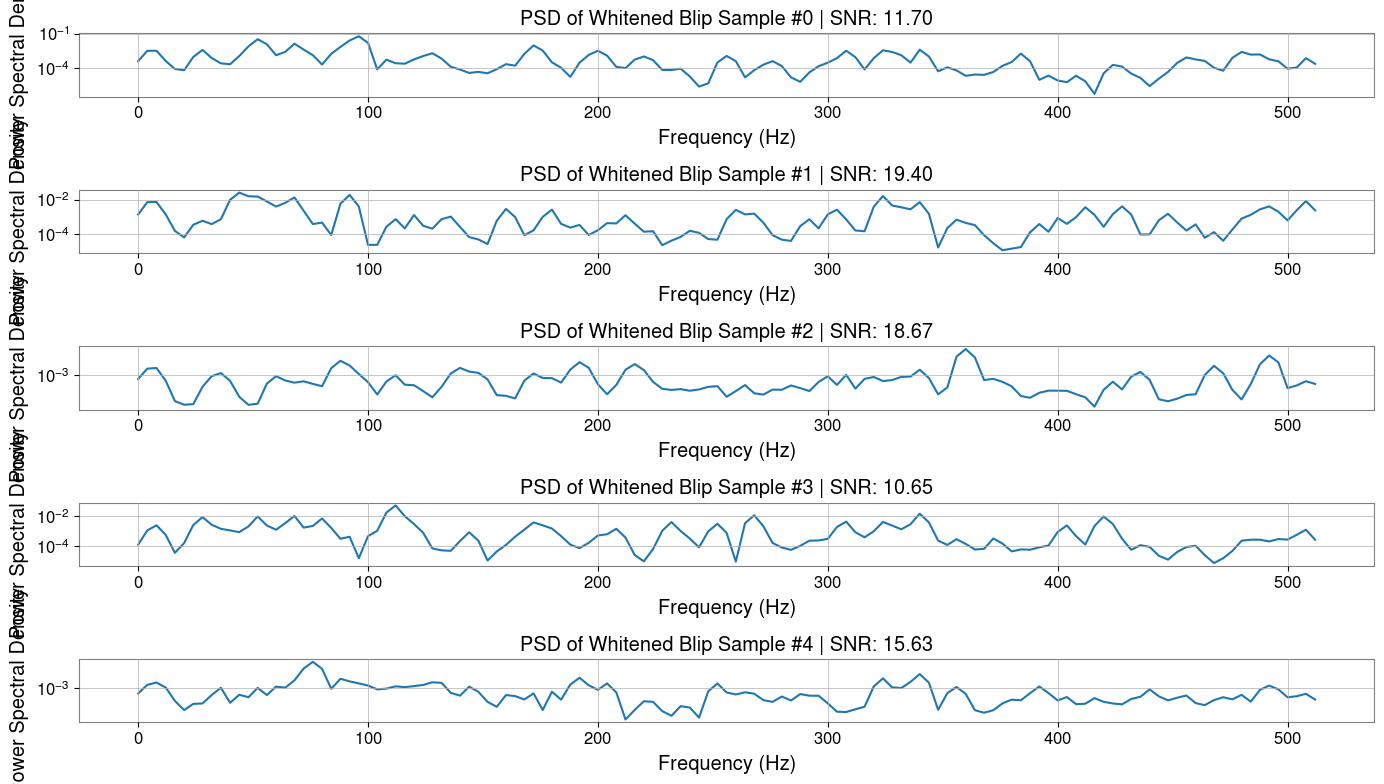

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

data = np.load("blip_real_noise_whitened_10k.npz")
X_whitened = data["X"]
snrs = data["snr"]
sample_rate = 1024  # Hz

plt.figure(figsize=(14, 8))

for i in range(5):
    sample = X_whitened[i]
    freqs, psd = welch(sample, fs=sample_rate, nperseg=256)

    plt.subplot(5, 1, i + 1)
    plt.semilogy(freqs, psd)
    plt.title(f"PSD of Whitened Blip Sample #{i} | SNR: {snrs[i]:.2f}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density")

plt.tight_layout()
plt.show()




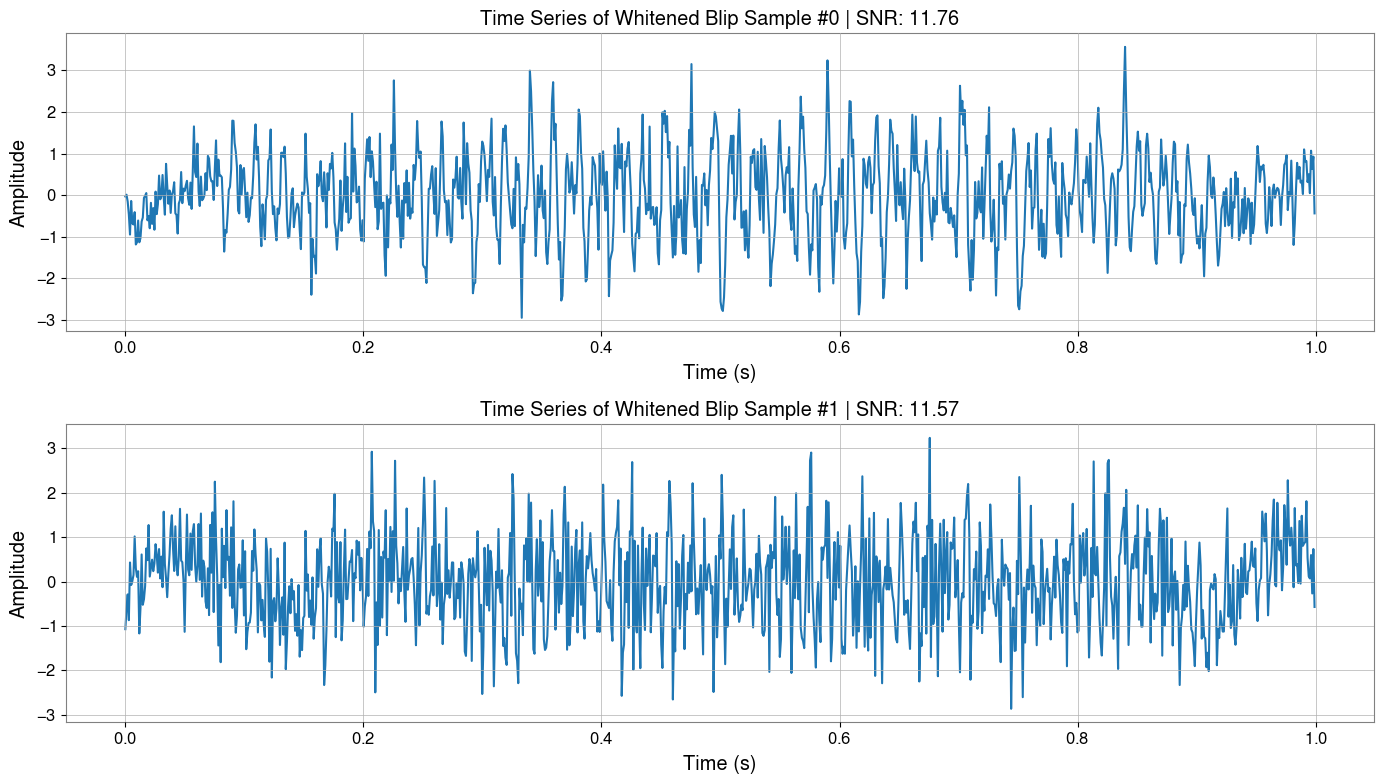

In [7]:
import numpy as np
import matplotlib.pyplot as plt


data = np.load("blip_real_noise_whitened_10k.npz")
X_whitened = data["X"]
snrs = data["snr"]
sample_rate = 1024  
duration = 1.0  


t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)


n_plot = min(3, len(X_whitened))


plt.figure(figsize=(14, 4 * n_plot))

for i in range(n_plot):
    sample = X_whitened[i]
    plt.subplot(n_plot, 1, i + 1)
    plt.plot(t, sample)
    plt.title(f"Time Series of Whitened Blip Sample #{i} | SNR: {snrs[i]:.2f}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()
